In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve,classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [2]:
from platform import python_version
print(python_version())

3.6.10


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Load Dataset

In [4]:
data = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/conversion_project.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
for column in data.columns:
    uniques=sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)),uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [8]:
for column in data.columns:
    uniques=sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)),uniques[-5:])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [73, 77, 79, 111, 123]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [25, 26, 27, 28, 29]
converted                2	 [0, 1]


## Remove outliers

In [9]:
data[data['age']>90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [10]:
data=data[data['age']<100]

## Exploratory Data Analysis

In [11]:
#Visualization of different countries
grouped= data[['country','converted']].groupby('country').mean().reset_index()
grouped.head()

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


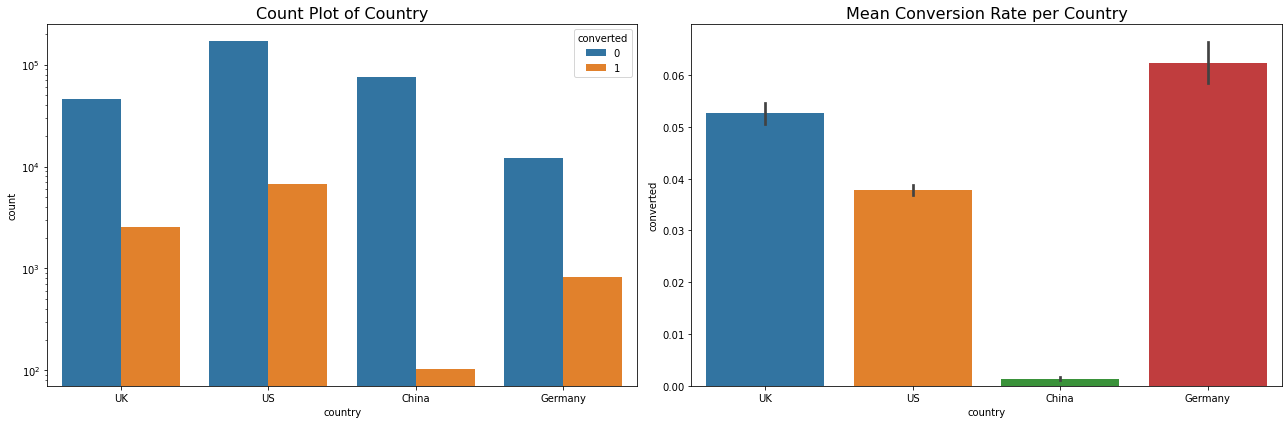

In [12]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='country',hue='converted',data=data,ax=ax[0])
ax[0].set_title('Count Plot of Country',fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country',y='converted',data=data,ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country',fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
#Visualization of different user types
grouped= data[['new_user','converted']].groupby('new_user').mean().reset_index()
grouped.head()

,new_user,converted
0,0,0.071983
1,1,0.014021


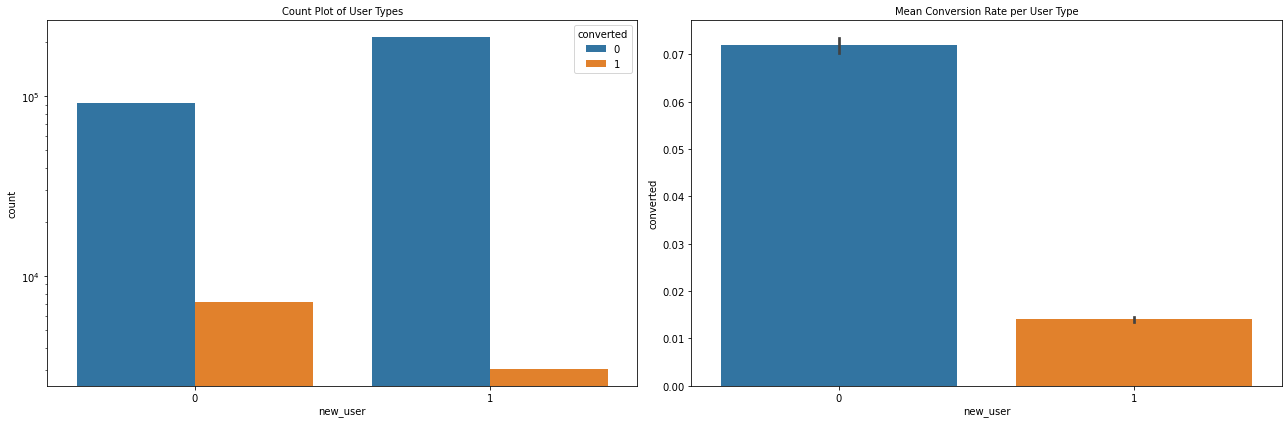

In [14]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='new_user',hue='converted',data=data,ax=ax[0])
ax[0].set_title('Count Plot of User Types',fontsize=10)
ax[0].set_yscale('log')
sns.barplot(x='new_user',y='converted',data=data,ax=ax[1])
ax[1].set_title('Mean Conversion Rate per User Type',fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
#Visualization of different sources
grouped= data[['source','converted']].groupby('source').mean().reset_index()
grouped.head()

,source,converted
0,Ads,0.034472
1,Direct,0.028169
2,Seo,0.032888


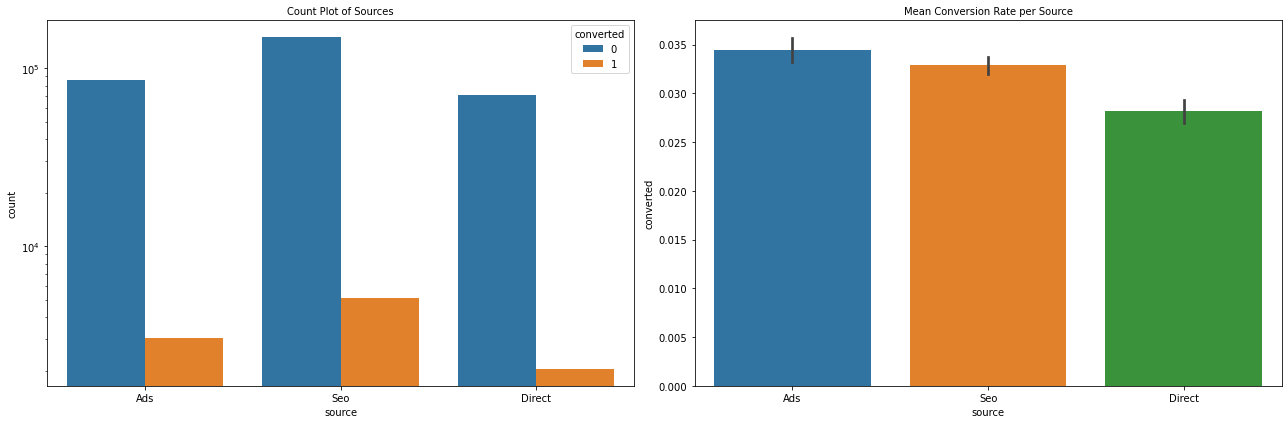

In [16]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='source',hue='converted',data=data,ax=ax[0])
ax[0].set_title('Count Plot of Sources',fontsize=10)
ax[0].set_yscale('log')
sns.barplot(x='source',y='converted',data=data,ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source',fontsize=10)
plt.tight_layout()
plt.show()

In [17]:
#Visualization of different Age
grouped= data[['age','converted']].groupby('age').mean().reset_index()
grouped.head()

,age,converted
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


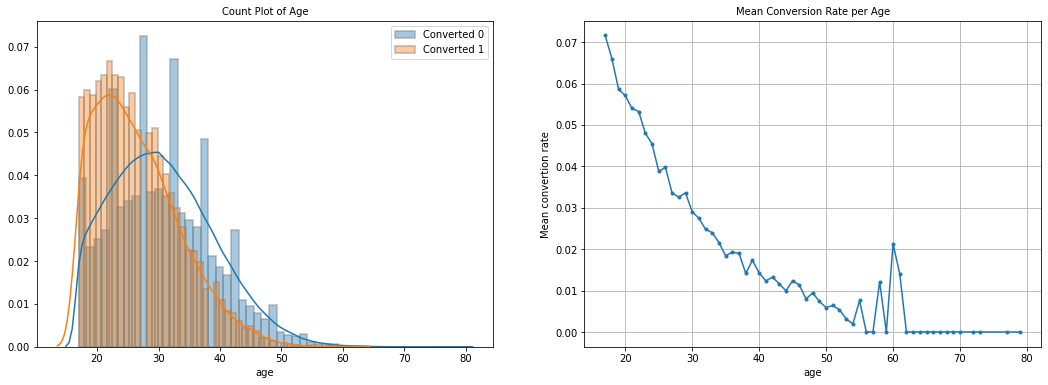

In [18]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(data[data['converted']==0]['age'],label='Converted 0',ax=ax[0],hist_kws=dict(edgecolor="gray", linewidth=2))
sns.distplot(data[data['converted']==1]['age'],label='Converted 1',ax=ax[0],hist_kws=dict(edgecolor="gray", linewidth=2))
ax[0].set_title('Count Plot of Age',fontsize=10)
ax[0].legend()
ax[1].plot(grouped['age'],grouped['converted'],'.-')
ax[1].set_title('Mean Conversion Rate per Age',fontsize=10)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

In [19]:
data1=data['age']
data1.describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [20]:
data2=data[data['converted']==0]['age']
data2.describe()

count    306000.000000
mean         30.703961
std           8.275779
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [21]:
data3=data[data['converted']==1]['age']
data3.describe()

count    10198.000000
mean        26.529025
std          6.937305
min         17.000000
25%         21.000000
50%         25.000000
75%         31.000000
max         61.000000
Name: age, dtype: float64

In [22]:
#Visualization of different Page visited
grouped= data[['total_pages_visited','converted']].groupby('total_pages_visited').mean().reset_index()
grouped.head()

,total_pages_visited,converted
0,1,0.000000
1,2,0.000228
2,3,0.000251
3,4,0.000780
4,5,0.001570


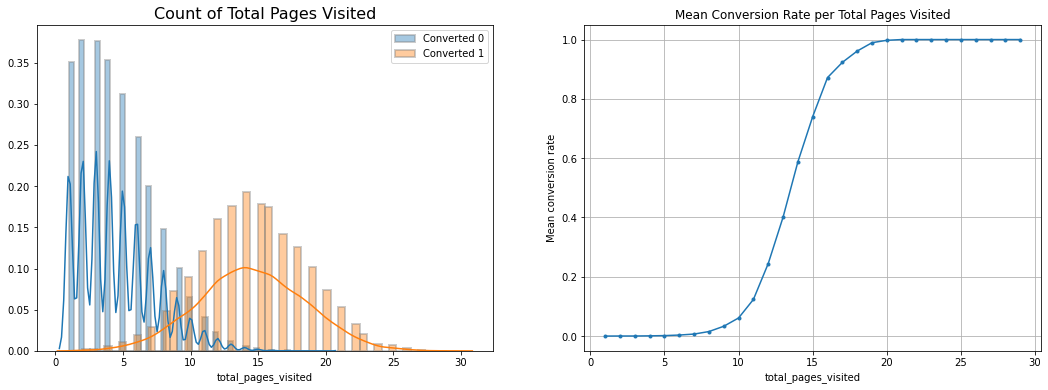

In [23]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(data[data['converted']==0]['total_pages_visited'],label='Converted 0', 
             ax=ax[0], hist_kws=dict(edgecolor="gray", linewidth=2))
sns.distplot(data[data['converted']==1]['total_pages_visited'],label='Converted 1', 
             ax=ax[0], hist_kws=dict(edgecolor="gray", linewidth=2))
ax[0].legend()
ax[0].set_title("Count of Total Pages Visited", fontsize=16)
ax[1].plot(grouped['total_pages_visited'],grouped['converted'],'.-')
ax[1].set_title("Mean Conversion Rate per Total Pages Visited")
ax[1].set_xlabel("total_pages_visited")
ax[1].set_ylabel("Mean conversion rate")
ax[1].grid(True)
plt.show()

## Machine Learning

In [24]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.162-b12, mixed mode)
  Starting server from D:\Anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DELL\AppData\Local\Temp\tmpayguml2q
  JVM stdout: C:\Users\DELL\AppData\Local\Temp\tmpayguml2q\h2o_ALEX_started_from_python.out
  JVM stderr: C:\Users\DELL\AppData\Local\Temp\tmpayguml2q\h2o_ALEX_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,7 months and 10 days !!!
H2O_cluster_name:,H2O_from_python_ALEX_p33zun
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [25]:
h2o_df=H2OFrame(data)
h2o_df.head()
h2o_df['new_user']=h2o_df['new_user'].asfactor() #important
h2o_df['converted']=h2o_df['converted'].asfactor() #important
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [26]:
# Split into 75% training and 25% test dataset
strat_split=h2o_df['converted'].stratified_split(test_frac=0.25,seed=42)

train=h2o_df[strat_split=='train']
test=h2o_df[strat_split=='test']

feature=['country','new_user','age','source','total_pages_visited']
target='converted'

In [27]:
# Build random forest model
model=H2ORandomForestEstimator(balance_classes=True,ntrees=100,max_depth=20,mtries=-1,seed=42,
                              score_each_iteration=True)
model.train(x=feature,y=target,training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


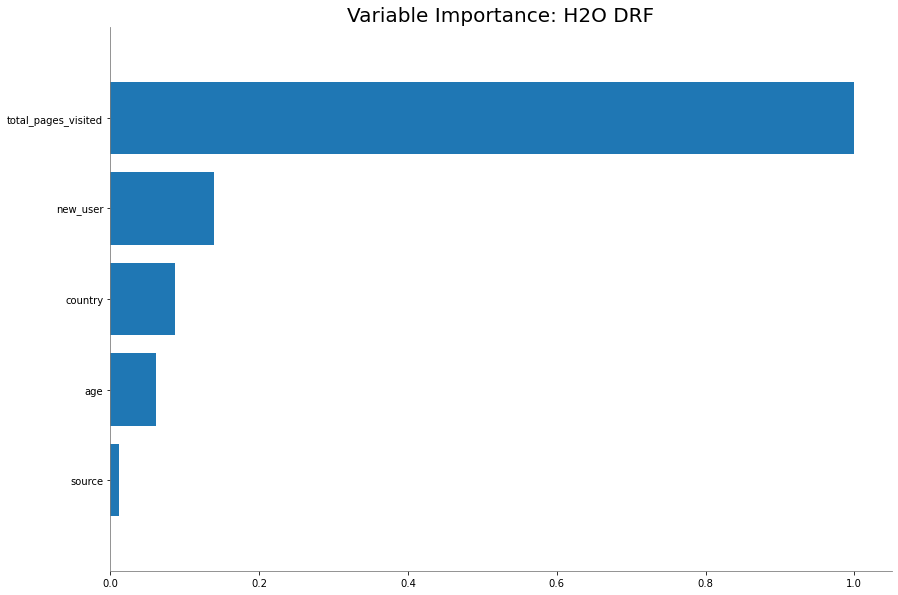

In [30]:
model.varimp_plot()

              variable  relative_importance  scaled_importance  percentage
0  total_pages_visited         6.009332e+06           1.000000    0.769353
1             new_user         8.379513e+05           0.139442    0.107280
2              country         5.249283e+05           0.087352    0.067205
3                  age         3.664189e+05           0.060975    0.046911
4               source         7.226071e+04           0.012025    0.009251


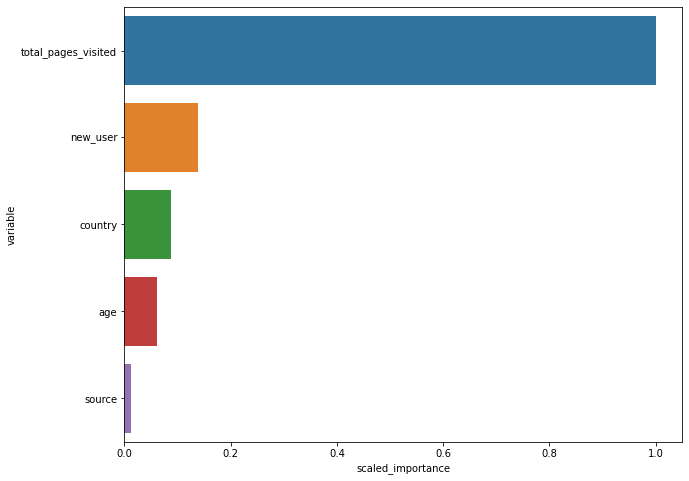

In [28]:
# Feature importance
importance= model.varimp(use_pandas=True)
print(importance.head())
fig,ax=plt.subplots(figsize=(10,8))
#sns.barplot(x='scaled_importance', y='variable', data=importance)
sns.barplot(x=importance['scaled_importance'],y=importance['variable'])
plt.show()

In [29]:
# Make predictions
train_true=train.as_data_frame()['converted'].values # remove index, only keep values as array 
print(train_true)
test_true=test.as_data_frame()['converted'].values
train_pred=model.predict(train).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1
test_pred=model.predict(test).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1

train_fpr,train_tpr,_=roc_curve(train_true,train_pred)
test_fpr,test_tpr,_=roc_curve(test_true,test_pred)
train_auc=np.round(auc(train_fpr,train_tpr),3)
test_auc=np.round(auc(test_fpr,test_tpr),3)

[0 0 0 ... 0 0 0]
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
# Classification report
print(classification_report(y_true=test_true,y_pred=(test_pred>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.86     79050
weighted avg       0.98      0.98      0.98     79050



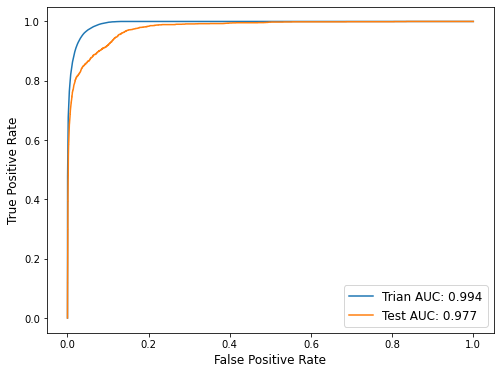

In [32]:
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(train_fpr,train_tpr,label='Trian AUC: '+str(train_auc))
ax.plot(test_fpr,test_tpr,label='Test AUC: '+str(test_auc))
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


D:\Anaconda3\envs\py36\lib\site-packages\h2o\model\model_base.py:1359: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


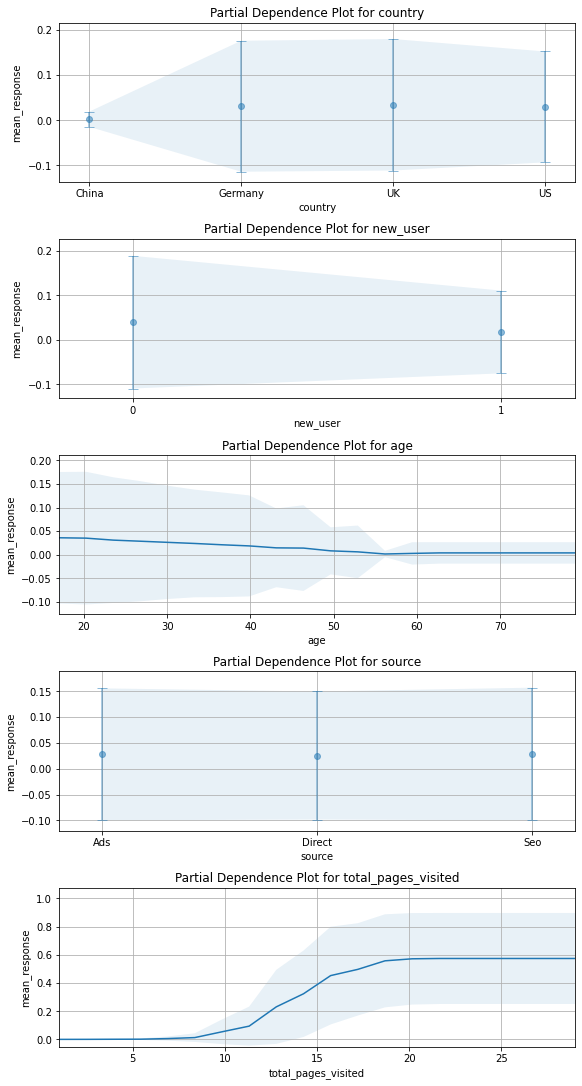

In [33]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [34]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8f75 closed.


## Additional Analysis - Logistic Regression

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection  import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [36]:
feature=['country','new_user','age','source','total_pages_visited']
target='converted'
x=data[feature]
x=pd.get_dummies(x)# OHE those categorical features
y=data[target]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.333)
ytrain.mean(),ytest.mean()

(0.0324365588134886, 0.03188215852755143)

In [37]:
lrcv=LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
lrcv.fit(xtrain,ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.7s remaining:   35.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     max_iter=1000, n_jobs=-1, scoring='roc_auc', verbose=1)

In [38]:
lrcv.C_

array([10.])

In [39]:
lrcv.scores_

{1: array([[0.98417648, 0.98657245, 0.98703423, 0.98703664, 0.98703668,
         0.98703668, 0.98703668],
        [0.98268295, 0.98565193, 0.98645065, 0.98656323, 0.98656329,
         0.98656329, 0.98656323],
        [0.98093504, 0.98408904, 0.98469959, 0.9847007 , 0.984699  ,
         0.984699  , 0.984699  ],
        [0.98370448, 0.98626862, 0.98691267, 0.98697837, 0.98698004,
         0.98698004, 0.98698004],
        [0.98293641, 0.98571447, 0.98635764, 0.98641618, 0.98641936,
         0.98641936, 0.98641936]])}

In [40]:
lrcv.score(xtrain,ytrain)

0.9863615842235444

In [41]:
lrcv.score(xtest,ytest)

0.9854034237954697

In [42]:
1 - ytest.mean()

0.9681178414724486

In [43]:
# Classification report
ytest_predict = lrcv.predict(xtest)
print(classification_report(y_true=ytest,y_pred=ytest_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101937
           1       0.85      0.68      0.76      3357

    accuracy                           0.99    105294
   macro avg       0.92      0.84      0.88    105294
weighted avg       0.99      0.99      0.99    105294



In [44]:
feat_importances=pd.DataFrame({"Variable Name":xtrain.columns,"Coef":lrcv.coef_[0]})
feat_importances['importances'] = np.abs( feat_importances['Coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances.reset_index(drop=True, inplace=True) # reorder the index with simple sequential numbers
feat_importances

,Variable Name,Coef,importances
0,country_China,-2.703705,2.703705
1,new_user,-1.713564,1.713564
2,country_Germany,1.109346,1.109346
3,country_UK,0.922067,0.922067
4,total_pages_visited,0.760423,0.760423
5,country_US,0.570205,0.570205
6,source_Direct,-0.162213,0.162213
7,age,-0.075262,0.075262
8,source_Ads,0.051247,0.051247
9,source_Seo,0.008879,0.008879


From above model, we can draw below conclusion:

1. conversion among China users are very bad. from inspection, we know that there are lot of users coming from China, but their conversion rate is very low. Consider China's economic and population, there is a huge opportunity if we target Chinese users and improve their conversion rate. we should consider whether our website has good Chinese translation and satisfy Chinese users' culture requirement.
2. conversion from Germany is good. but inspection, we know that there isn't a lot of users from German. so it's a huge opportuntity for us to target German users. for example, put more advertisement in German.
3. old users have better conversion rate. we should keep touch with them, for example, send promotion email or coupons to old users.
4. age is a negative factor. the older the user is, the less likely he/she will convert. then we should figure out why young people loves the web pages and strengthen it. and also find out why older people doesn't like our web pages, and try to correct it.
5. total_pages_visited is a positive factor. the longer the user browse our web page, the more likely he/she will convert and buy something. then if we find some user browse a lot and didn't buy anything, we can send email to remaind them.